<a href="https://colab.research.google.com/github/alex-pakalniskis/ua-womens-hackathon-2019/blob/master/womens_hackathon_python_geospatial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free cloud computing with Google Drive
#### A GIS programming workshop

[Alex Pakalniskis](https://alexpakalniskis.com)



![GIS photo](https://new.library.arizona.edu/sites/default/files/styles/featured_image/public/featured_media/gislayers.png?itok=TzJ28PPD)
![GRASS GIS](https://grasswiki.osgeo.org/w/images/thumb/Wxgui-pyshell.png/400px-Wxgui-pyshell.png)

In [0]:
# Install curl (https://curl.haxx.se/), g++ (https://en.wikipedia.org/wiki/GNU_Compiler_Collection), and make (https://en.wikipedia.org/wiki/Make_(software)) on the remote machine you are using
!apt-get install -qq curl g++ make
# Use curl to download zippied spatial indexing software from Open Source Geospatial Foundation (https://www.osgeo.org/) and use tar to unzip
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
# Python library for operating system specific tasks such as changing directories (https://docs.python.org/3/library/os.html)
import os
# Change current working directory to newly unzipped OSGEO spatial indexing software
os.chdir('spatialindex-src-1.8.5')
# Configure software and dependencies for install on remote Google computer
!./configure
# Build software from its Makefile (https://en.wikipedia.org/wiki/Makefile) by invoking make (https://en.wikipedia.org/wiki/Make_(software))
!make
# Copy built software and files to correct locations for accessing later
!make install
# Use pip Python package manager (https://en.wikipedia.org/wiki/Pip_(package_manager)) to install rtree (http://toblerity.org/rtree/)
# Python-wrapper for libspatialindex, a C++ library (https://libspatialindex.org/) for implementing R-tree data access (https://en.wikipedia.org/wiki/R-tree)
# http://toblerity.org/rtree/
!pip install rtree
# Configure (symbolic) links with ldconfig (https://linux.die.net/man/8/ldconfig)
!ldconfig
# Import rtree and sublibraries. Can use for large data indexing, but we will likely not use it for this workshop demonstration. Go forth and experiment! Have fun. 
import rtree
from rtree import index
from rtree.index import Rtree
# Check for packages which need updating and install the development branch of libspatialindex onto the remote Google cloud computer with a linux OS
!sudo apt-get update && apt-get install -y libspatialindex-dev
# Install descartes (https://pypi.org/project/descartes/) to enable plotting planar geometric vector objects in matplotlib
!pip install descartes
# Spatial version of Pandas library for GIS data management and basic analyses (http://geopandas.org/)
!pip install geopandas 
# Geographic data science library (https://pysal.readthedocs.io/en/latest/)
!pip install pysal
# Choropleth mapping schemes from the makers of PySAL (https://github.com/pysal/mapclassify)
!pip install mapclassify
# Library for zonal statistics and interpolated point queries (https://pythonhosted.org/rasterstats/)
!pip install rasterstats
# Python-wrapper for leaflet.js JavaScript interactive mapping library (https://python-visualization.github.io/folium/)
!pip install folium
# Upgrade the software
!sudo apt-get upgrade


(Reading database ... 131236 files and directories currently installed.)
Preparing to unpack .../libcurl4-openssl-dev_7.58.0-2ubuntu3.8_amd64.deb ...
Unpacking libcurl4-openssl-dev:amd64 (7.58.0-2ubuntu3.8) over (7.58.0-2ubuntu3.7) ...
Preparing to unpack .../curl_7.58.0-2ubuntu3.8_amd64.deb ...
Unpacking curl (7.58.0-2ubuntu3.8) over (7.58.0-2ubuntu3.7) ...
Preparing to unpack .../libcurl4_7.58.0-2ubuntu3.8_amd64.deb ...
Unpacking libcurl4:amd64 (7.58.0-2ubuntu3.8) over (7.58.0-2ubuntu3.7) ...
Setting up libcurl4:amd64 (7.58.0-2ubuntu3.8) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up libcurl4-openssl-dev:amd64 (7.58.0-2ubuntu3.8) ...
Setting up curl (7.58.0-2ubuntu3.8) ...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0   807k      0 --:--:-- --:--:-- --:--:--  807k
chec

In [0]:
# Set the current working directory to "home"
os.chdir("/home/")
# Data management and analysis library with emphasis on tabular data. Widely used in research and industry, as it was initially developed for financial analyses of stocks. Comes preloaded in Colaboratory. 
import pandas as pd
# Matrix algebra library for multidimensional arrays. Hugely popular in scientific computing. Based of the proprietary MATLAB software. Comes preloaded in Colaboratory. 
import numpy as np
import geopandas as gpd
# Legendary visualization library. Comes preloaded in Colaboratory. 
import matplotlib.pyplot as plt
# Great, newer visualization library built-on matplotlib but with more modern styling. Comes preloaded in Colaboratory. (https://seaborn.pydata.org/)
import seaborn as sns
# Colaboratory helper library for importing and downloading locally stored files into the remote Google machine
import google.colab.files
import pysal
import mapclassify
# Library for reading and writing geospatial raster data such as TIFFS (https://rasterio.readthedocs.io/en/stable/quickstart.html)
import rasterio
import rasterstats
# Pyplot sublibrary for legend styling
import matplotlib.patches as mpatches
import folium
from folium import plugins
from folium.plugins import MarkerCluster
from folium.plugins import MiniMap
# Scikit-image is a library of image processing algorithms including computer vision protocols
from skimage import data, io, segmentation, color, transform 
from skimage.future import graph
# Setting global plot style aesthetics through seaborn
sns.set(context="paper",
       palette="colorblind")

## Use Python to read and manipulate data from a public Google Sheet in Google Drive

In [0]:
# Google Sheet with information about Data Centers in Tucson, AZ. Includes Latitude and Longitude: Obtained October 2019
data_url = "https://docs.google.com/spreadsheets/d/1xOpiV58l76stT406ecqlc-wp8MqN3X-hCo-EJxouKsg/view#gid=0"

In [0]:
# There are also great Python libraries like gspread for more direct Google Sheets/Python integration
# For this workshop, I stuck with string manipulation in order to tweak the public-view Google Sheet URL into a downloadable CSV file
# Old suffix that I want to replace
google_suffix = "/view#gid=0"
# New suffix that I am providing
new_google_suffix = "/export?format=csv&gid=0"
# Use `replace` function to create a new string variable with the updated suffix
data = data_url.replace(google_suffix, new_google_suffix)

In [0]:
# Print the updated URL (formatted to download as a CSV file)
print(data)

https://docs.google.com/spreadsheets/d/1xOpiV58l76stT406ecqlc-wp8MqN3X-hCo-EJxouKsg/export?format=csv&gid=0


In [0]:
# Read the CSV-formatted data into Python with pandas
# Pandas is great and can read locally or remotely stored CSV and XLSX files 
df = pd.read_csv(data)

In [0]:
# Another commonly used term for this type of tabular dataset is a pandas DataFrame. 
# Also a term frequently used in R programming and their tidyerse. 
df

,Name,Address,Company,Latitude,Longitude
0,Involta Data Center,1215 E. Pennsylvania St,Involta,32.172309,-110.954107
1,Level 3 Tucson,135 N. 6th Avenue,Level 3 Communications,32.224111,-110.968976
2,Login DC2,1855 N 6th Ave,"Login, LLC",32.244957,-110.969154
3,Login Top-Tier Data Center,"4003 East Speedway Boulevard, Ste 119","Login, LLC",32.237377,-110.906989
4,Simply Bits Vault,5225 N. Sabino Canyon,Simply Bits LLLC,32.302180,-110.824644
5,tw telecom Tucson,3836 S Evans Blvd,tw telecom,32.176295,-110.953551


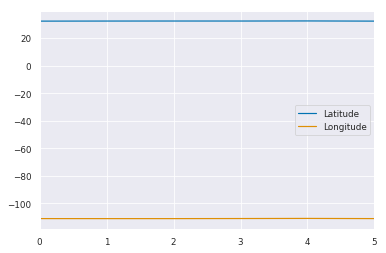

In [146]:
df.plot()

Wut? Not the most descriptive or enlightening of figures. 

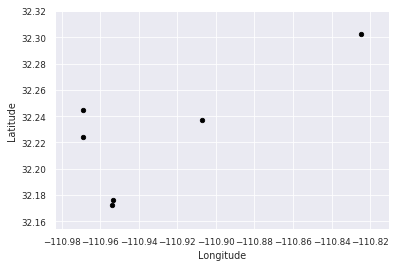

In [143]:
# Let's use pandas scatter plot function to make a hacky but simple figure of the Tucson data center locations
df.plot.scatter(y="Latitude", x="Longitude", color="black")

In [0]:
# Convert the spreadsheet into a geospatial dataset by joining "Latitude" and "Longitude" into a single Point geometry
# The point geometries can be plotted on maps such as those depicting city boundaries. 
# Using GeoDataFrames instead of DataFrames will generally simplify any plotting or analysis. 
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [0]:
gdf

,Name,Address,Company,Latitude,Longitude,geometry
0,Involta Data Center,1215 E. Pennsylvania St,Involta,32.172309,-110.954107,POINT (-110.95411 32.17231)
1,Level 3 Tucson,135 N. 6th Avenue,Level 3 Communications,32.224111,-110.968976,POINT (-110.96898 32.22411)
2,Login DC2,1855 N 6th Ave,"Login, LLC",32.244957,-110.969154,POINT (-110.96915 32.24496)
3,Login Top-Tier Data Center,"4003 East Speedway Boulevard, Ste 119","Login, LLC",32.237377,-110.906989,POINT (-110.90699 32.23738)
4,Simply Bits Vault,5225 N. Sabino Canyon,Simply Bits LLLC,32.302180,-110.824644,POINT (-110.82464 32.30218)
5,tw telecom Tucson,3836 S Evans Blvd,tw telecom,32.176295,-110.953551,POINT (-110.95355 32.17630)


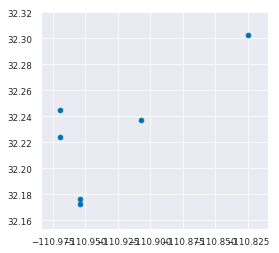

In [134]:
gdf.plot()

See how much less code that requires?

Let's plot a few other layers to make the map a bit nicer looking
We'll use some data from Tucson Open Data portal for GIS (http://gisdata.tucsonaz.gov/) and PublicaMundi (http://www.publicamundi.eu/).

In [306]:
# GeoJSON data of state boundaries in USA
states_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
# Read state boundary file using geopandas
states = gpd.read_file(states_url)


,id,name,density,geometry
0,01,Alabama,94.650,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
2,04,Arizona,57.050,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,05,Arkansas,56.430,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,06,California,241.700,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."
5,08,Colorado,49.330,"POLYGON ((-107.91973 41.00391, -105.72895 40.9..."
6,09,Connecticut,739.100,"POLYGON ((-73.05353 42.03905, -71.79931 42.022..."
7,10,Delaware,464.300,"POLYGON ((-75.41409 39.80446, -75.50720 39.683..."
8,11,District of Columbia,10065.000,"POLYGON ((-77.03526 38.99387, -76.90929 38.895..."
9,12,Florida,353.400,"POLYGON ((-85.49714 30.99754, -85.00421 31.003..."
10,13,Georgia,169.500,"POLYGON ((-83.10919 35.00118, -83.32279 34.787..."


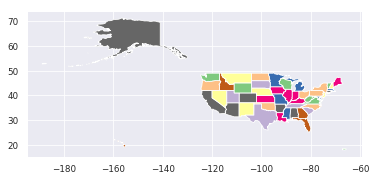

In [337]:
states.plot(cmap="Accent_r")

In [338]:
# Create a subset of the data for the continental US
continental = states.drop([1,11,51])
continental

,id,name,density,geometry
0,01,Alabama,94.650,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
2,04,Arizona,57.050,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,05,Arkansas,56.430,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,06,California,241.700,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."
5,08,Colorado,49.330,"POLYGON ((-107.91973 41.00391, -105.72895 40.9..."
6,09,Connecticut,739.100,"POLYGON ((-73.05353 42.03905, -71.79931 42.022..."
7,10,Delaware,464.300,"POLYGON ((-75.41409 39.80446, -75.50720 39.683..."
8,11,District of Columbia,10065.000,"POLYGON ((-77.03526 38.99387, -76.90929 38.895..."
9,12,Florida,353.400,"POLYGON ((-85.49714 30.99754, -85.00421 31.003..."
10,13,Georgia,169.500,"POLYGON ((-83.10919 35.00118, -83.32279 34.787..."


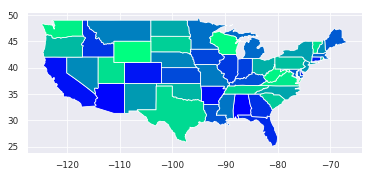

In [340]:
continental.plot(cmap="winter")

In [0]:
# You can also create a variable for random color plotting. There will be as many colors/numbers as there are states in the continental US (48) + District of Columbia (1).
vals = np.linspace(0,1,len(continental))
vals

In [0]:
# Shuffle the values to the colorramp is randomized
np.random.shuffle(vals)
# Generate a randomized 256-gradation colormap from the pyplot "Winter" default
cmap = plt.cm.colors.ListedColormap(plt.cm.winter(vals))
# Generate a pyplot figure 
fig, ax = plt.subplots(figsize=(10,6))
# Plot the continental US with the randomized "Winter" colormap
continental.plot(ax=ax, cmap=cmap)
# Set the x and y limits of the plot to the x and y limits of the pyplot axis and not the bounds including Alaska and Hawaii
cont_xlim = ax.get_xlim()
cont_ylim = ax.get_ylim()

In [341]:
# Jurisdiction boundary data (http://gisdata.tucsonaz.gov/datasets/jurisdiction-boundaries-open-data)
zones = "https://opendata.arcgis.com/datasets/b53bbe832e4e4d94a31730b596487d28_0.geojson"
# Use geopandas to read in the geojson data
zones_gdf = gpd.read_file(zones)
# Display the first five lines of the data set
zones_gdf.head()

,OBJECTID,NAME,INCORP,PC_UID,DATASOURCE,ShapeSTArea,ShapeSTLength,geometry
0,1,UNINCORPORATED PIMA COUNTY,0,1,JURISBND,9.585057e+04,1379.783793,"POLYGON ((-110.94073 32.40304, -110.94052 32.4..."
1,2,UNINCORPORATED PIMA COUNTY,0,2,JURISBND,9.621820e+04,1580.119375,"POLYGON ((-110.93731 32.40581, -110.93721 32.4..."
2,3,UNINCORPORATED PIMA COUNTY,0,3,JURISBND,8.352943e+05,4004.425876,"POLYGON ((-111.10837 32.37616, -111.10841 32.3..."
3,4,SAHUARITA,1,4,JURISBND,8.706792e+08,182264.339048,"POLYGON ((-110.94470 31.99865, -110.95101 31.9..."
4,5,UNINCORPORATED PIMA COUNTY,0,5,JURISBND,4.130680e+07,41961.670916,"POLYGON ((-111.09745 32.51126, -111.09745 32.5..."


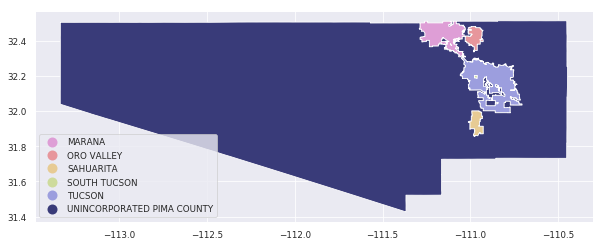

In [353]:
# Plot the jurisdictional boundary data
# Use column "NAME" for choropleth mapping
# Feel free to change the colormap to another matplotlib colormap (https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html)
zones_gdf.plot(column="NAME",cmap="tab20b_r", legend=True, figsize=(10,5), legend_kwds={'loc': 'lower left'})

In [0]:
# And some street data (http://gisdata.tucsonaz.gov/datasets/major-streets-and-routes-open-data)
# Again we'll use geopandas to read in the geojson data
tucson_streets = gpd.read_file("https://opendata.arcgis.com/datasets/c6d21082e6d248f0b7db0ff4f6f0ed8e_7.geojson")
# And plot the first five rows of the data set
tucson_streets.head()

,OBJECTID,MSR_INT,STREET,MSR_TYPE,MS_R_FUTUR,Future,MSR_FTR_,INT_B,INT_C,INT_D,URL,DATASOURCE,ORIG_FID,MSR_ID,MAINTAINED_BY,STATUS,ShapeSTLength,geometry
0,1,1.0,E ANDRADA RD,ARTERIAL,300,1.0,300.0,200.0,300.0,300.0,http://www.tucsonaz.gov/sites/default/files/im...,MAJSTRRTES,1.0,None,CITY OF TUCSON,effectuated,599.777463,"LINESTRING (-110.85920 31.99085, -110.85726 31..."
1,2,1.0,E ANDRADA RD,ARTERIAL,300,1.0,300.0,200.0,300.0,300.0,http://www.tucsonaz.gov/sites/default/files/im...,MAJSTRRTES,2.0,None,CITY OF TUCSON,effectuated,599.835656,"LINESTRING (-110.82415 31.99076, -110.82222 31..."
2,3,1.0,E ANDRADA RD,ARTERIAL,300,1.0,300.0,200.0,300.0,300.0,http://www.tucsonaz.gov/sites/default/files/im...,MAJSTRRTES,3.0,None,CITY OF TUCSON,effectuated,599.831618,"LINESTRING (-110.82608 31.99083, -110.82562 31..."
3,4,1.0,E ANDRADA RD,ARTERIAL,300,1.0,300.0,200.0,300.0,300.0,http://www.tucsonaz.gov/sites/default/files/im...,MAJSTRRTES,4.0,None,CITY OF TUCSON,effectuated,445.777061,"LINESTRING (-110.77433 31.99059, -110.77291 31..."
4,5,1.0,S RITA RD,ARTERIAL,150,1.0,150.0,150.0,300.0,300.0,http://www.tucsonaz.gov/sites/default/files/im...,MAJSTRRTES,5.0,None,CITY OF TUCSON,effectuated,320.275622,"LINESTRING (-110.82422 31.99163, -110.82415 31..."


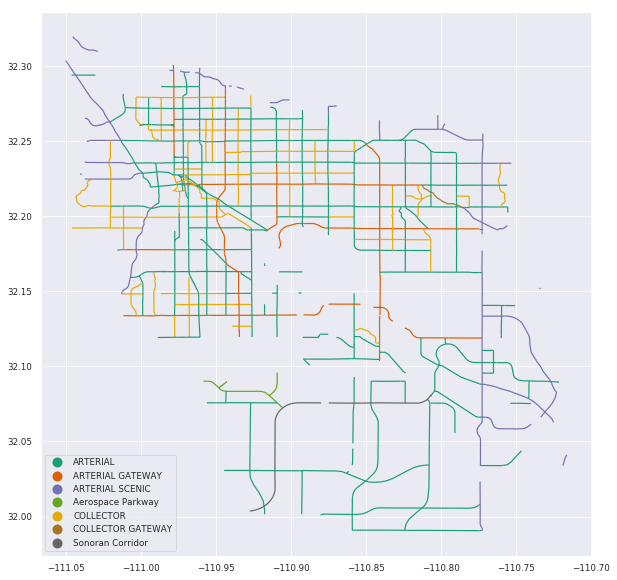

In [303]:
# Plot the street network data
# Use column "NAME" for choropleth mapping
# Feel free to change the colormap to another matplotlib colormap (https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html)
tucson_streets.plot(column="MSR_TYPE",cmap="Dark2", legend=True, figsize=(10,10), legend_kwds={'loc': 'lower left'})

Let's put it all together to map the data centers in Tucson

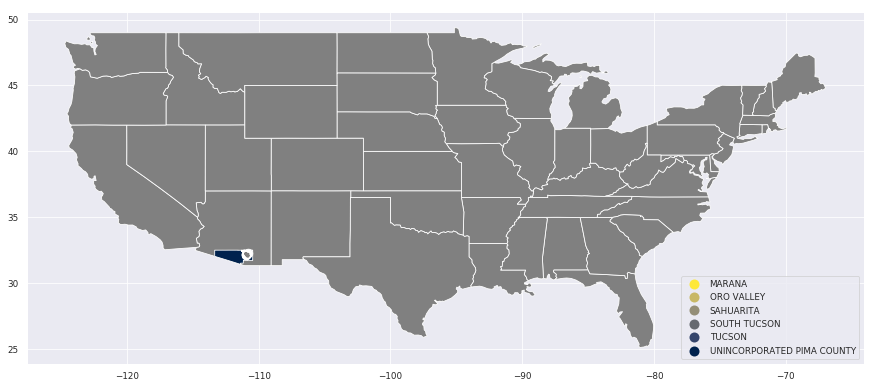

In [354]:
# Create a matplotlib figure with a single axis 
fig, ax = plt.subplots(figsize=(15,8))
# Plot the continental united states on the axis
continental.plot(ax=ax, color="gray")
# Plot the southern Arizona administrative boundaries
zones_gdf.plot(ax=ax, column="NAME", cmap="cividis_r", legend=True, legend_kwds={'loc': 'lower right'})
# Plot Tucson major streets and roads
tucson_streets.plot(ax=ax, color="gray", hatch="..")
# Plot the data center locations
gdf.plot(ax=ax, color="white", marker="o", markersize=75)



Not ideal. Let's tweak the axis extent using the boundary information of the data center dataframe

In [355]:
print(gdf.total_bounds)

[-110.969154   32.172309 -110.824644   32.30218 ]


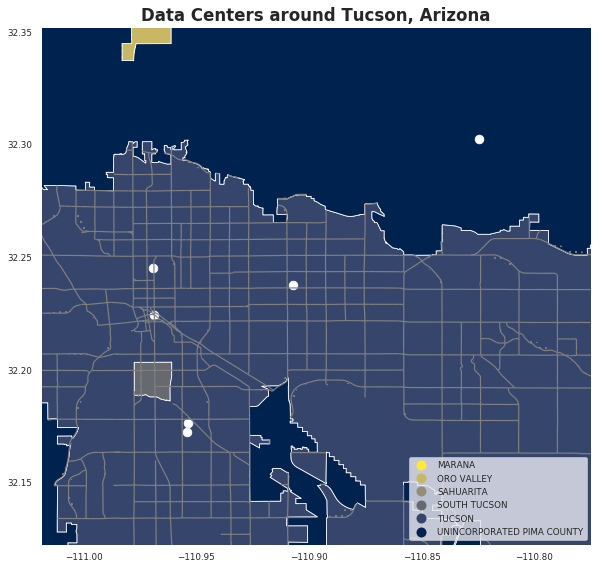

In [356]:
# Create a matplotlib figure with a single axis 
fig, ax = plt.subplots(figsize=(15,8))
# Plot the continental united states on the axis
continental.plot(ax=ax, color="gray")
# Plot the southern Arizona administrative boundaries
zones_gdf.plot(ax=ax, column="NAME", cmap="cividis_r", legend=True, legend_kwds={'loc': 'lower right'})
# Plot Tucson major streets and roads
tucson_streets.plot(ax=ax, color="gray", hatch="..")
# Plot the data center locations
gdf.plot(ax=ax, color="white", marker="o", markersize=75)
# Adjust x and y limits to the total bounds of the data center data
ax.set_xlim(gdf.total_bounds[0]-0.05, gdf.total_bounds[2]+0.05)
ax.set_ylim(gdf.total_bounds[1]-0.05, gdf.total_bounds[3]+0.05)
# Set the figure title
plt.title("Data Centers around Tucson, Arizona", fontsize="xx-large", fontweight="bold")
# Implement tight layout. Entirely optional. 
plt.tight_layout()
# Save to the "home" directory on the Google virtual machine
plt.savefig("data_centers_tucson.png")

In [0]:
# Create a variable for the newly created map image
my_photo = "/home/data_centers_tucson.png"
# Read the first of three image layers as a numpy array
my_data = io.imread(my_photo)[:,:,0]

In [357]:
my_data

Array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

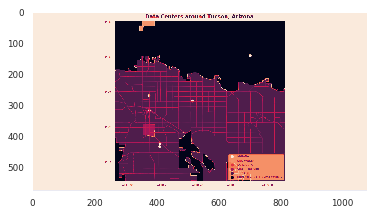

In [368]:
plt.imshow(my_data)
plt.grid(False)

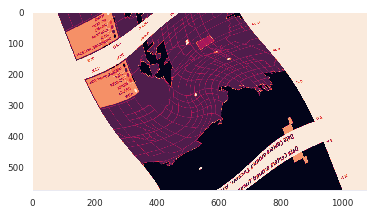

In [404]:
# Use an image processing algorithm to swirl your map data. Have fun and adjust the parameters like rotation, strength, and radius. Also add in your own data. 
swrld = transform.swirl(my_data, rotation=1455, strength=2, radius=1000)
# Create a matplotlib figure
fig, ax = plt.subplots()
# Set the swirled image to the axis
ax.imshow(swrld)
# Turn of axis grid lines
ax.grid(False)



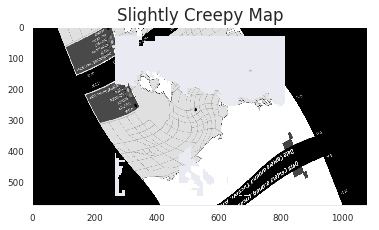

In [454]:
plt.imshow(swrld / my_data*my_data*0.9, cmap="Greys")
plt.grid(False)
plt.title("Slightly Creepy Map", fontsize="xx-large")
plt.savefig("/home/creepy_map.png")

Let's make some interactive maps

In [427]:
# Display the default map from folium
m = folium.Map(control_scale=True)
m

In [429]:
# Let's use some custom tiles from CartoDB. This requires the tiles and an attribution. 
tiles = "https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png"
attr = '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>'
m = folium.Map(tiles=tiles,attr=attr,control_scale=True)
m

In [438]:
# Let's zoom into a location on Earth. I've semi-randomly chosen a latitude and longitude coordinate, then zoomed in for visualization purposes. 
m = folium.Map(location=[57,-4],
               zoom_start=5,
               tiles=tiles,
               attr=attr,
               control_scale=True)
m

In [440]:
# What about inset maps (which are also interactive). Let's use a different base map provider to contrast the figure aesthetics. 
mini_map_tiles = "Stamen Toner"

m = folium.Map(location=[57,-4],
               zoom_start=5,
               tiles=tiles,
               attr=attr,
               control_scale=True)

minimap = plugins.MiniMap(toggle_display=True,
                          tile_layer=mini_map_tiles,
                          width=100)
  
m.add_child(minimap) 


m

In [446]:
#Let's create a list of the coordinates of Tucson Data Centers. This will come in handy for mapping the data. 
coordinates = gdf[['Latitude', 'Longitude']]
coordinates_list = coordinates.values.tolist()
# Calculate the average Latitude and Longitude to center the map perfectly on the Data Center data set
mean_lat=gdf['Latitude'].mean() 
mean_lon=gdf['Longitude'].mean() 
# Create a variable called "location" to be invoked in a folium map
location = [mean_lat, mean_lon]
location

[32.226204833333334, -110.92957016666666]

In [447]:
m = folium.Map(location=location,
                 tiles = tiles,
                 attr=attr,
                 control_scale=True, zoom_start=7) 

MarkerCluster(locations=coordinates_list, popups=df["Name"]).add_to(m)

minimap = plugins.MiniMap(toggle_display=True, 
                            tile_layer=mini_map_tiles,
                           width=100)
  
m.add_child(minimap) 

m

In [444]:
m = folium.Map(location=location,
               
                 tiles = tiles,
               
                 attr=attr,
               
                 control_scale=True) 

MarkerCluster(locations=coordinates_list, popups=df["Name"]).add_to(m)
# Can also call the fit_bounds method to fit the interactive map neatly to the bounds of the coordinates_list previously generated
m.fit_bounds([coordinates_list])

minimap = plugins.MiniMap(toggle_display=True,
                            
                            tile_layer=mini_map_tiles,
                           
                           width=100)
  
m.add_child(minimap) 

m

In [0]:
m.save("tucson_data_centers.html")

In [0]:
google.colab.files.download("/home/tucson_data_centers.html")

In [0]:
google.colab.files.download("/home/creepy_map.png")